## **1. Introduction** 

**Import libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
sns.set_style('darkgrid')

**Load Data**

In [3]:
url = 'https://raw.githubusercontent.com/minhtpham/ibm_watson_auto_policy/main/data/IBM-Marketing-Customer-Value.csv'

data = pd.read_csv(url)

In [4]:
data.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


**Describe data**

In [5]:
print("Data size: ", data.shape)

Data size:  (9134, 24)


In [6]:
numCols = list(data.select_dtypes(exclude='object').columns)
print(f"There are {len(numCols)} numerical features:\n", numCols)

There are 8 numerical features:
 ['Customer Lifetime Value', 'Income', 'Monthly Premium Auto', 'Months Since Last Claim', 'Months Since Policy Inception', 'Number of Open Complaints', 'Number of Policies', 'Total Claim Amount']


In [7]:
catCols = list(data.select_dtypes(include='object').columns)
print(f"There are {len(catCols)} categorical features:\n", catCols)

There are 16 categorical features:
 ['Customer', 'State', 'Response', 'Coverage', 'Education', 'Effective To Date', 'EmploymentStatus', 'Gender', 'Location Code', 'Marital Status', 'Policy Type', 'Policy', 'Renew Offer Type', 'Sales Channel', 'Vehicle Class', 'Vehicle Size']


## **2. Exploratory Data Analysis**

There's no duplicated rows in this dataset

In [8]:
duplicate_rows = data[data.duplicated()]
print('Number of duplicate rows: ', duplicate_rows.shape)

Number of duplicate rows:  (0, 24)


#### **I. Customer Lifetime Value**

In [9]:
x = data['Customer Lifetime Value']
print(x.describe())

count     9134.000000
mean      8004.940475
std       6870.967608
min       1898.007675
25%       3994.251794
50%       5780.182197
75%       8962.167041
max      83325.381190
Name: Customer Lifetime Value, dtype: float64


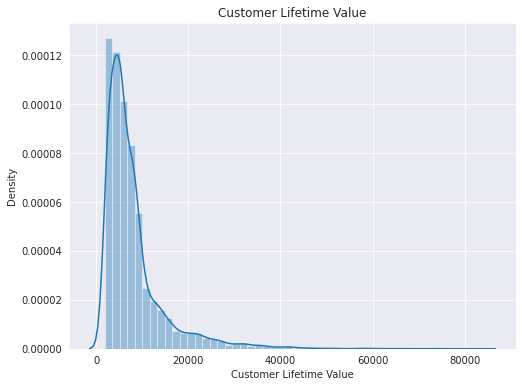

In [10]:
plt.figure(figsize=(8,6))
sns.distplot(x)
title = plt.title("Customer Lifetime Value")

In [11]:
print(f"""Skewness: {x.skew()}
Kurtosis: {x.kurt()}""")

Skewness: 3.032280259929985
Kurtosis: 13.823533425442404


The distribution of Customer Lifetime Value is right skewed.


In [12]:
## renaming 'Customer Lifetime Value' colume to 'clv' so it's easier to type. 
data = data.rename({'Customer Lifetime Value' : 'clv'}, axis=1)

#### **II. Numerical Features**

**Using Correlation**

Top 5 numerical features correlated with Customer Lifetime Value:

In [13]:
correlation_matrix = data.corr().clv.sort_values(ascending = False)
correlation_matrix.head(6)

clv                        1.000000
Monthly Premium Auto       0.396262
Total Claim Amount         0.226451
Income                     0.024366
Number of Policies         0.021955
Months Since Last Claim    0.011517
Name: clv, dtype: float64

It looks like only Monthly Premium Auto and Total Claim Amount have some significant. The other correlations are small. 

**Using Recursive Feature Elimination**

Top 5 numerical features selected using Linear Regression

In [14]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select = 5, step = 1)
selector = selector.fit(data.fillna(0).select_dtypes(exclude = 'object'), x)
rfe_features = list(data.select_dtypes(exclude = 'object').columns[selector.support_])
rfe_features

['clv',
 'Months Since Last Claim',
 'Months Since Policy Inception',
 'Number of Open Complaints',
 'Number of Policies']

Only 1 common variable - Number of Policies! Let's take a look at Number of Policies, Monthly Premium Amount, Total Claim Amount, Months Since Last Claim, and Months Since Policy Inception.  

**Number of Policies**

In [15]:
data['Number of Policies'].describe()

count    9134.000000
mean        2.966170
std         2.390182
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max         9.000000
Name: Number of Policies, dtype: float64

Number of policies can go all the way up to 9, with consumers averaging around 2 policies. 

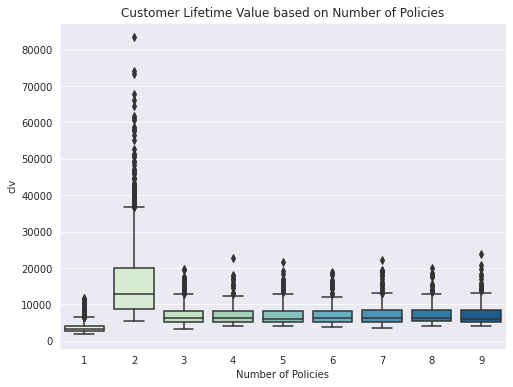

In [16]:
plt.figure(figsize = (8,6))
sns.boxplot(x = 'Number of Policies', y = 'clv', data = data, palette = 'GnBu')
title = plt.title('Customer Lifetime Value based on Number of Policies')

It's interesting that customers with 2 policies have higher Customer Lifetime Value than ones with 9 policies. 

**Monthly Premium Amount**

The correlation is  0.3962617375340225


<Figure size 432x432 with 0 Axes>

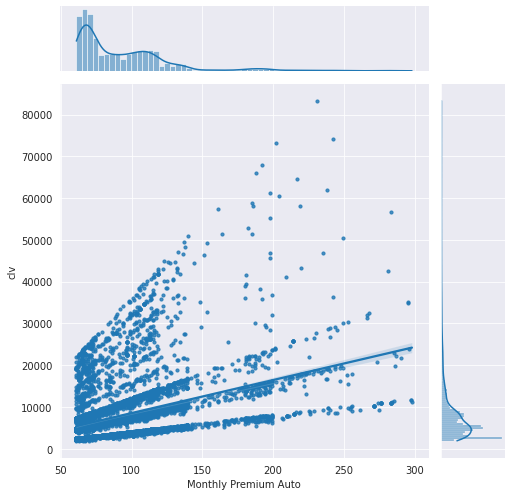

In [17]:
def plotCorrelation(our_variables):

  #Create plot
  plt.figure(figsize = (6,6))
  sns.jointplot(
      data[(our_variables[0])],
      data[(our_variables[1])],
      kind = 'reg',
      height = 7,
      scatter_kws = {'s':10},
      marginal_kws = {'kde':True}
  )

  #Print Correlation
  print("The correlation is ", data[[our_variables[0],our_variables[1]]].corr().iloc[1,0])

plotCorrelation(['Monthly Premium Auto','clv'])

It looks like the correlation is a bit messy, but there is a general upward trend; meaning that higher Monthly Premium leads to higher Customer Lifetime Value. 

**Total Claim Amount**

The correlation is  0.22645091528641614


<Figure size 432x432 with 0 Axes>

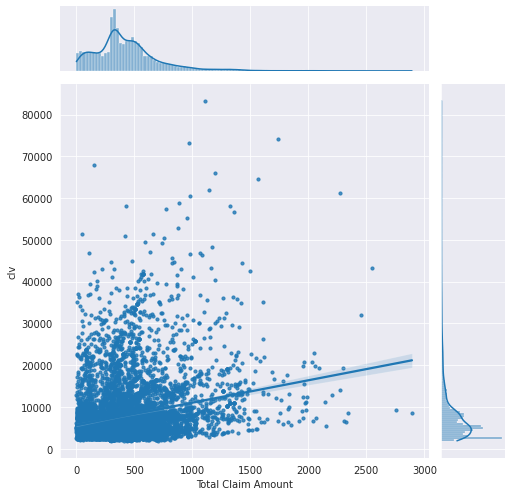

In [18]:
plotCorrelation(['Total Claim Amount','clv'])

Customers who claims more (totally) probably stays with the company longer, and have higher CLV.

**Months Since Last Claim**

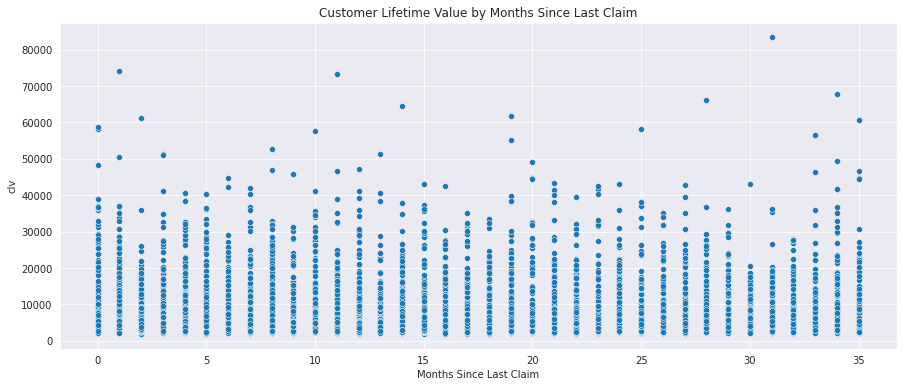

In [19]:
plt.figure(figsize = (15,6))
sns.scatterplot(x = 'Months Since Last Claim', y = 'clv', data = data)
title = plt.title('Customer Lifetime Value by Months Since Last Claim')

Doesn't look like Months Since Last Claim matters that much, as all the x-axis points have similiar heights. 

**Months Since Policy Inception**

The correlation is  0.009418381244490763


<Figure size 432x432 with 0 Axes>

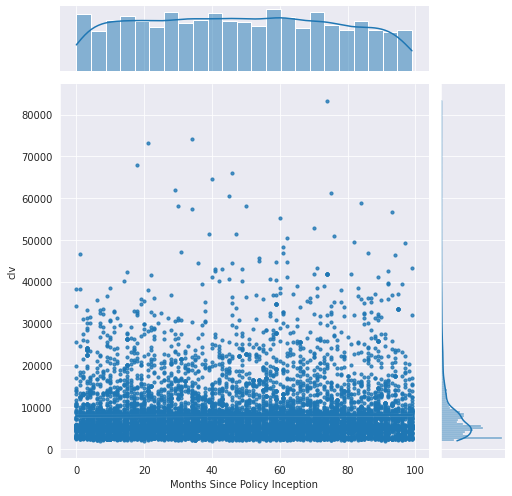

In [20]:
plotCorrelation(['Months Since Policy Inception','clv'])

It's interesting that there's no correlation between months since policy inception (a proxy for brand loyalty) and customer lifetime value. It doesn't matter how long the customers is with the company. 

#### **III. Categorical Features**

I choose to look at the following categorical features, based on my common sense and intuition. 


1.   Coverage
2.   Education
3.   Employment Status
4.   Gender
5.   Location Code
6.   Marital Status
7.   Policy Type
8.   Sales Channel
9.   Vehicle Class
10.  State


In [21]:
def visualizeCatFeature(catfeature):
  # Visualization: sort by clv descending 
  featureOrder = data.groupby(catfeature).median().clv.sort_values(ascending = False).index

  # Box plot
  sns.boxplot(
      x = catfeature,
      y = 'clv',
      data = data, 
      order = featureOrder,
      palette = 'GnBu_r'
  )

**Coverage**

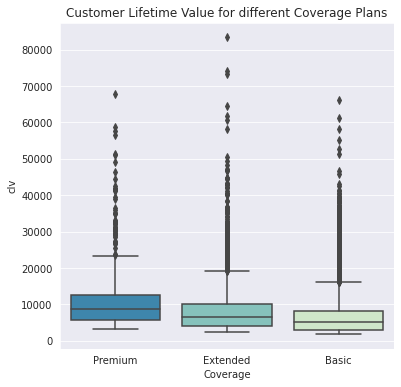

In [22]:
plt.figure(figsize = (6,6))
visualizeCatFeature('Coverage')
title = plt.title('Customer Lifetime Value for different Coverage Plans')

Premium has the highest CLV, which makes sense.

**Vehicle Class**

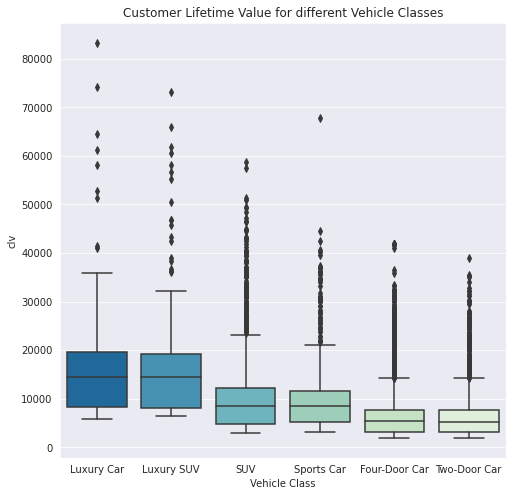

In [23]:
plt.figure(figsize = (8,8))
visualizeCatFeature('Vehicle Class')
title = plt.title('Customer Lifetime Value for different Vehicle Classes')

Luxury car has the highest CLV, which makes sense. 

#### **IV. Correlation Heatmap**

ValueError: ignored

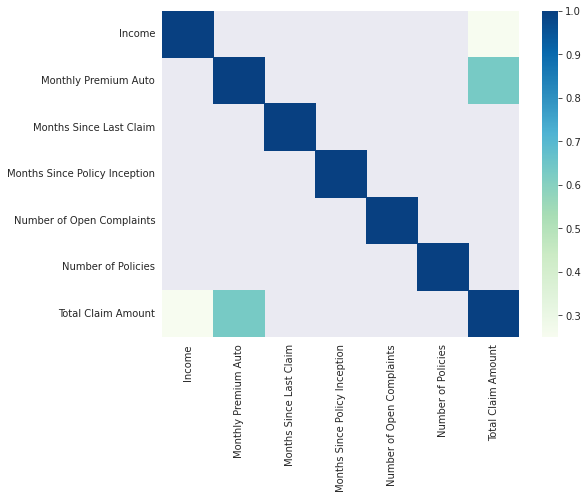

In [24]:
# Create correlation matrix
c_matrix = data.iloc[:,[1,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]].corr()
# Correlation > 0.25
some_corr = c_matrix[abs(c_matrix) > 0.25]

plt.figure(figsize = (8,6))
sns.heatmap(
    some_corr,
    annot = True,
    fmt = '.lf',
    cmap = 'GnBu',
    vmin = 0.25,
    vmax = 1.0
)

title = plt.title('Correlation Heatmap')